# Project: Identify Customer Segments

In this project, I applied unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data are provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import markdown
import codecs
from bs4 import BeautifulSoup
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(azdias.head())
print(azdias.describe())

(891221, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1        

In [4]:
print(feat_info.shape)
print(feat_info.head())
print(feat_info.describe())
print(feat_info)

(85, 4)
              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]
         attribute information_level     type missing_or_unknown
count           85                85       85                 85
unique          85                 9        5                  9
top     SEMIO_KAEM            person  ordinal               [-1]
freq             1                43       49                 26
                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
feat_num = azdias.shape[1]
azdias_trans = azdias.copy()
miss_values = {}
for i in range(feat_num):
    if feat_info['missing_or_unknown'][i] != '[]':
    # when feat_info['missing_or_unknown'][i] == '[]', the corresponding columns have been treated with np.nan
        miss_value_strings = feat_info['missing_or_unknown'][i][1:-1].split(',')
        miss_value_set = set()
        for string in miss_value_strings:
            try:
                miss_value_set.add(int(string))
            except:
                miss_value_set.add(string)
        azdias_trans.iloc[:,i] = azdias_trans.iloc[:,i].apply(lambda x: np.nan if x in miss_value_set else x)
    miss_values[i] = (azdias_trans.iloc[:,i].isna().sum() / len(azdias_trans.iloc[:,i]), \
                      azdias_trans.iloc[:,i].isna().sum(), \
                      len(azdias_trans.iloc[:,i]), \
                      azdias_trans.columns[i])

print(miss_values)


{0: (0.7695543529607134, 685843, 891221, 'AGER_TYP'), 1: (0.0032326437550282143, 2881, 891221, 'ALTERSKATEGORIE_GROB'), 2: (0.0, 0, 891221, 'ANREDE_KZ'), 3: (0.005446460529992, 4854, 891221, 'CJT_GESAMTTYP'), 4: (0.0, 0, 891221, 'FINANZ_MINIMALIST'), 5: (0.0, 0, 891221, 'FINANZ_SPARER'), 6: (0.0, 0, 891221, 'FINANZ_VORSORGER'), 7: (0.0, 0, 891221, 'FINANZ_ANLEGER'), 8: (0.0, 0, 891221, 'FINANZ_UNAUFFAELLIGER'), 9: (0.0, 0, 891221, 'FINANZ_HAUSBAUER'), 10: (0.0, 0, 891221, 'FINANZTYP'), 11: (0.4402028228688507, 392318, 891221, 'GEBURTSJAHR'), 12: (0.005446460529992, 4854, 891221, 'GFK_URLAUBERTYP'), 13: (0.0, 0, 891221, 'GREEN_AVANTGARDE'), 14: (0.12476815514894735, 111196, 891221, 'HEALTH_TYP'), 15: (0.10954858559212585, 97632, 891221, 'LP_LEBENSPHASE_FEIN'), 16: (0.10611509378706292, 94572, 891221, 'LP_LEBENSPHASE_GROB'), 17: (0.08728699166648901, 77792, 891221, 'LP_FAMILIE_FEIN'), 18: (0.08728699166648901, 77792, 891221, 'LP_FAMILIE_GROB'), 19: (0.005446460529992, 4854, 891221, 'LP_S

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [6]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_data_counts = [miss_values[i][1] for i in range(feat_num)]
print(missing_data_counts)
print(len(missing_data_counts))


[685843, 2881, 0, 4854, 0, 0, 0, 0, 0, 0, 0, 392318, 4854, 0, 111196, 97632, 94572, 77792, 77792, 4854, 4854, 108315, 108164, 4854, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 111196, 73499, 889061, 111196, 0, 310267, 73499, 73499, 18348, 584612, 147988, 73499, 99611, 97008, 93148, 73969, 93148, 93148, 93148, 99352, 99352, 99352, 133324, 133324, 133324, 133324, 476524, 133324, 93740, 93740, 93740, 93155, 158064, 133324, 4854, 158064, 105800, 116515, 116515, 116515, 116515, 116515, 116515, 116515, 97375, 97274, 97375]
85


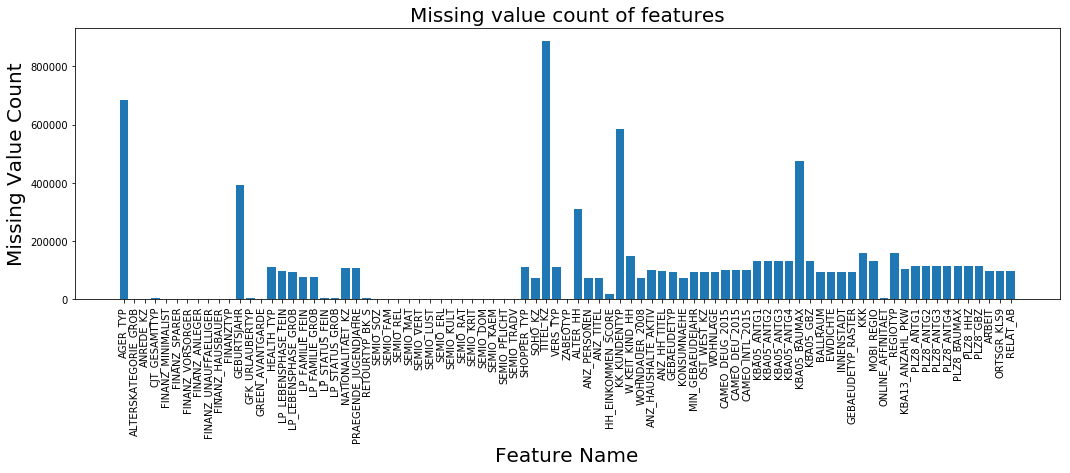

In [7]:
# Investigate patterns in the amount of missing data in each column.
names = [miss_values[i][3] for i in range(feat_num)]
values = missing_data_counts

plt.figure(1, figsize=(60, 5))


plt.subplot(131)
plt.bar(names, values)
plt.xticks(rotation=90)
plt.xlabel('Feature Name', fontsize=20)
plt.ylabel('Missing Value Count', fontsize=20)
plt.title('Missing value count of features', fontsize=20)
plt.show()


In [8]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
removed_features = []
for v in miss_values.values():
    if v[1] > 0.5 * azdias_trans.shape[0]:
        removed_features.append(v[3])
        azdias_trans = azdias_trans.drop(v[3], axis=1)
print(azdias_trans.shape)
print(removed_features)

(891221, 81)
['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Answer:
There are some patterns in the features which have a large number of miss values. First, some of those features are abstract/ambiguous. For example, feature 'KK_KUNDENTYP' includes the information about consumer pattern over past 12 months. But the options, stray customer/inactive customer/passive customer, are kinda vague. In the case, people may choose the option 'unknown' for the question. Besides, some features target at some specific groups of people, e.g. feature 'AGER_TYP' and 'TITEL_KZ'. People who are not in the groups may choose the option 'unknown'.

The columns I removed include 'AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', and 'KBA05_BAUMAX'. My criterion is the percentage of the mssing values in the column. If over 50% of the cells have missing values in a column, I remove this column.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [9]:
# How much data is missing in each row of the dataset?
missing_in_raws = azdias_trans.isnull().sum(axis=1)
missing_in_raws

0         45
1          1
2          0
3          7
4          0
5          0
6          2
7          0
8          0
9          0
10         0
11        49
12         7
13         8
14        49
15         8
16         6
17        49
18         5
19         2
20        12
21         2
22         2
23         9
24        49
25         5
26        21
27         1
28         0
29         2
          ..
891191     0
891192     1
891193     0
891194     0
891195     1
891196     0
891197     0
891198     0
891199     2
891200     1
891201     0
891202     2
891203    16
891204     0
891205     0
891206     0
891207     0
891208     3
891209     2
891210     2
891211     0
891212     1
891213     0
891214     0
891215     2
891216     3
891217     4
891218     5
891219     1
891220     2
Length: 891221, dtype: int64

In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_threshold = 0.5

azdias_trans_nonmissing_raws = azdias_trans.dropna(axis=0, thresh=int(azdias_trans.shape[1]*missing_threshold), inplace=False)

azdias_trans_missing_indices = azdias_trans.index.difference(azdias_trans_nonmissing_raws.index)
azdias_trans_missing_raws = azdias_trans.iloc[azdias_trans_missing_indices]
print(azdias_trans_nonmissing_raws.shape)
print(azdias_trans_missing_raws.shape)

(817178, 81)
(74043, 81)


In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
missing_percentage_threshold = 0.05
nonmissing_columns = []
for k in miss_values.values():
    if k[0] <= missing_percentage_threshold:
        nonmissing_columns.append(k[3])
print(nonmissing_columns)
print(len(nonmissing_columns))
selected_column_index = random.sample(range(len(nonmissing_columns)), 5)
print(selected_column_index)
selected_column = [nonmissing_columns[i] for i in selected_column_index]
print(selected_column)

def distribution_comparison(column):
    sns.set(style="white", palette="muted", color_codes=True)
    f, axes = plt.subplots(1, 2, figsize=(7, 3))

    sns.countplot(x=column, data=azdias_trans_nonmissing_raws, ax=axes[0])
    sns.countplot(x=column, data=azdias_trans_missing_raws, ax=axes[1])

    plt.setp(axes, yticks=[])
    plt.tight_layout()

['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP', 'HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET']
32
[22, 10, 17, 21, 6]
['SEMIO_KULT', 'GFK_URLAUBERTYP', 'SEMIO_REL', 'SEMIO_ERL', 'FINANZ_ANLEGER']


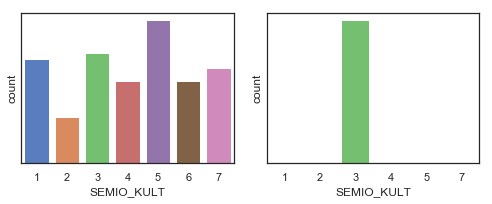

In [12]:
# column1 comparison
distribution_comparison(selected_column[0])

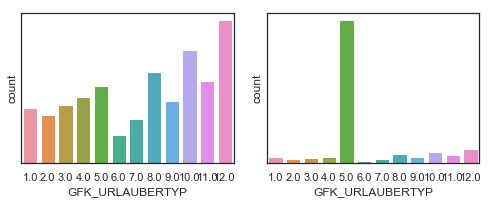

In [13]:
# column2 comparison
distribution_comparison(selected_column[1])

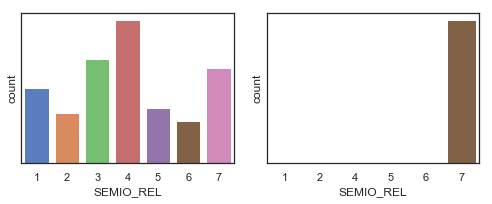

In [14]:
# column3 comparison
distribution_comparison(selected_column[2])

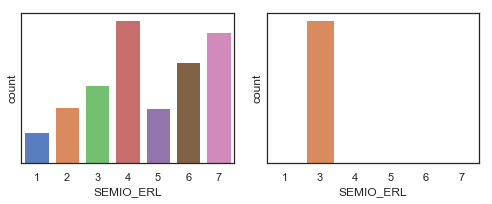

In [15]:
# column4 comparison
distribution_comparison(selected_column[3])

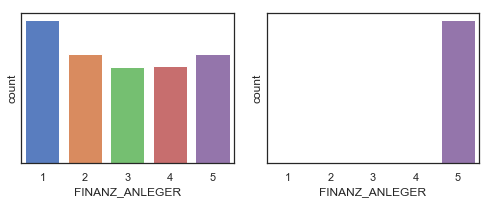

In [16]:
# column5 comparison
distribution_comparison(selected_column[4])

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Answer: 
Yes, there are differences between the two subsets. An interesting finding from the column 'GFK_URLAUBERTYP' is that people who are nature fans for vacation tend to have more missing values in their data. Since those people might stay in the wild for a long time, it is hard to get them finishing the surveys.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
print(feat_info['type'].value_counts())

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# step 1: features with only a few or without missing values 
feat_selected = feat_info.copy()
for feature in removed_features:
    feat_selected.drop(feat_selected[feat_selected['attribute']==feature].index, inplace=True)
print('number of features with only a few or without missing values :', feat_selected.shape[0])

# step 2: categorical features with only a few or without missing values 
categorical_feat = feat_selected.drop(feat_selected[feat_selected['type']!='categorical'].index)['attribute'].tolist()
print('number of categorical features with only a few or without missing values :', len(categorical_feat))

# step 3: binary/multi-level features with only a few or without missing values
binary_feat = {}
multi_feat = {}
for feature in categorical_feat:
    if len(azdias_trans.loc[:,feature].value_counts()) > 2:
        multi_feat[feature] = len(azdias_trans.loc[:,feature].value_counts())
    else:
        binary_feat[feature] = len(azdias_trans.loc[:,feature].value_counts())
print('binary features: ', binary_feat)
print('multi_feat: ', multi_feat)
print('number of binary features: ', len(binary_feat.keys()))
print('number of multi-level features: ', len(multi_feat.keys()))


number of features with only a few or without missing values : 81
number of categorical features with only a few or without missing values : 18
binary features:  {'ANREDE_KZ': 2, 'GREEN_AVANTGARDE': 2, 'SOHO_KZ': 2, 'VERS_TYP': 2, 'OST_WEST_KZ': 2}
multi_feat:  {'CJT_GESAMTTYP': 6, 'FINANZTYP': 6, 'GFK_URLAUBERTYP': 12, 'LP_FAMILIE_FEIN': 11, 'LP_FAMILIE_GROB': 5, 'LP_STATUS_FEIN': 10, 'LP_STATUS_GROB': 5, 'NATIONALITAET_KZ': 3, 'SHOPPER_TYP': 4, 'ZABEOTYP': 6, 'GEBAEUDETYP': 7, 'CAMEO_DEUG_2015': 9, 'CAMEO_DEU_2015': 44}
number of binary features:  5
number of multi-level features:  13


In [19]:
# Re-encode categorical variable(s) to be kept in the analysis.
print('shape of the dataframe before categorical feature encoding: ', azdias_trans.shape)
azdias_trans_dummy = pd.get_dummies(azdias_trans, dummy_na=True, columns=categorical_feat)
print('shape of the dataframe after categorical feature encoding: ', azdias_trans_dummy.shape)

shape of the dataframe before categorical feature encoding:  (891221, 81)
shape of the dataframe after categorical feature encoding:  (891221, 219)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Answer:
Four features are removed from the original dataset because they have more than 50% missing values. After removal, 18 categorical features are kept. Five of them are binary features, and 13 of them are multi-level features. I used 'one-hot encoding' to convert the categorical values to integer data.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [20]:
mixed_feat = feat_selected.drop(feat_selected[feat_selected['type']!='mixed'].index)['attribute'].tolist()
print('There are ' + str(len(mixed_feat)) + ' mixed features, which are:\n', mixed_feat)

There are 6 mixed features, which are:
 ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [21]:
# common procedures for treatment of 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'

# step 1: load the data_dictionary file
input_file = codecs.open("Data_Dictionary.md", mode="r")
text = input_file.read()
dd_html = markdown.markdown(text)

# step 2: parse the parts of the mixed features
soup = BeautifulSoup(dd_html)
headings = soup.find_all("h3")
cat_dict = {}
def parse_data_info(string):
    cat_dict = {}
    for h in headings:
        if string in str(h):
            parsed_string = str(h.next_sibling.next_sibling)
            parsed_raw = parsed_string.split('\n')
            for raw in parsed_raw:
                if raw[0] == '-':
                    raw_element = raw.split(': ')
                    raw_value = raw_element[1]
                    if raw_value[-4:] == '</p>':
                        raw_value = raw_value[:-4]
                    try:
                        cat_no = int(raw_element[0][-2:])
                        if cat_no >= 1 and cat_no <= 100:
                            cat_dict[cat_no] = raw_value
                    except:
                        continue
    return cat_dict

In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
original_dict = parse_data_info('PRAEGENDE_JUGENDJAHRE')
generation_dict = {}
movement_dict = {}
for k, v in original_dict.items():
    year = int(v[:2])
    bi_move = 0
    k = float(k)
    if 'Mainstream' in v:
        bi_move = 1
    generation_dict[k] = year
    movement_dict[k] = bi_move

print('encoding of generation information: ', generation_dict)
print('encoding of movement information: ', movement_dict)

azdias_trans_dummy_mix1 = azdias_trans_dummy.copy()
generation = azdias_trans_dummy_mix1.loc[:,'PRAEGENDE_JUGENDJAHRE'].map(generation_dict, na_action=None)
movement = azdias_trans_dummy_mix1.loc[:,'PRAEGENDE_JUGENDJAHRE'].map(movement_dict, na_action=None)
gene_move = pd.DataFrame({'generation':generation, 'movement':movement}, columns=['generation', 'movement'])
azdias_trans_dummy_mix1 = pd.concat([azdias_trans_dummy_mix1, gene_move], axis=1)
print('generation column has been created: \n', azdias_trans_dummy_mix1.loc[:5, 'generation'])
print('movement column has been created: \n', azdias_trans_dummy_mix1.loc[:5, 'movement'])

azdias_trans_dummy_mix1.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
print('the shape of dataframe after dealing with (PRAEGENDE_JUGENDJAHRE)', azdias_trans_dummy_mix1.shape)

encoding of generation information:  {1.0: 40, 2.0: 40, 3.0: 50, 4.0: 50, 5.0: 60, 6.0: 60, 7.0: 60, 8.0: 70, 9.0: 70, 10.0: 80, 11.0: 80, 12.0: 80, 13.0: 80, 14.0: 90, 15.0: 90}
encoding of movement information:  {1.0: 1, 2.0: 0, 3.0: 1, 4.0: 0, 5.0: 1, 6.0: 0, 7.0: 0, 8.0: 1, 9.0: 0, 10.0: 1, 11.0: 0, 12.0: 1, 13.0: 0, 14.0: 1, 15.0: 0}
generation column has been created: 
 0     NaN
1    90.0
2    90.0
3    70.0
4    70.0
5    50.0
Name: generation, dtype: float64
movement column has been created: 
 0    NaN
1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
Name: movement, dtype: float64
the shape of dataframe after dealing with (PRAEGENDE_JUGENDJAHRE) (891221, 220)


In [23]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
original_dict = parse_data_info('CAMEO_INTL_2015')
wealth_dict = {}
life_stage_dict = {}
for k,_ in original_dict.items():
    wealth_dict[str(k)] = k //10
    life_stage_dict[str(k)] = k % 10
print('encoding of wealth information: ', wealth_dict)
print('encoding of life_stage information: ', life_stage_dict)

azdias_trans_dummy_mix1_mix2 = azdias_trans_dummy_mix1.copy()
wealth = azdias_trans_dummy_mix1_mix2.loc[:,'CAMEO_INTL_2015'].map(wealth_dict, na_action=None)
life_stage = azdias_trans_dummy_mix1_mix2.loc[:,'CAMEO_INTL_2015'].map(life_stage_dict, na_action=None)
wealth_lifestage = pd.DataFrame({'wealth':wealth, 'life_stage':life_stage}, columns=['wealth', 'life_stage'])
azdias_trans_dummy_mix1_mix2 = pd.concat([azdias_trans_dummy_mix1_mix2, wealth_lifestage], axis=1)
print('wealth column has been created: \n', azdias_trans_dummy_mix1_mix2.loc[:5, 'wealth'])
print('life-stage column has been created: \n', azdias_trans_dummy_mix1_mix2.loc[:5, 'life_stage'])

azdias_trans_dummy_mix1_mix2.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
print('the shape of dataframe after dealing with (CAMEO_INTL_2015)', azdias_trans_dummy_mix1_mix2.shape)

encoding of wealth information:  {'11': 1, '12': 1, '13': 1, '14': 1, '15': 1, '21': 2, '22': 2, '23': 2, '24': 2, '25': 2, '31': 3, '32': 3, '33': 3, '34': 3, '35': 3, '41': 4, '42': 4, '43': 4, '44': 4, '45': 4, '51': 5, '52': 5, '53': 5, '54': 5, '55': 5}
encoding of life_stage information:  {'11': 1, '12': 2, '13': 3, '14': 4, '15': 5, '21': 1, '22': 2, '23': 3, '24': 4, '25': 5, '31': 1, '32': 2, '33': 3, '34': 4, '35': 5, '41': 1, '42': 2, '43': 3, '44': 4, '45': 5, '51': 1, '52': 2, '53': 3, '54': 4, '55': 5}
wealth column has been created: 
 0    NaN
1    5.0
2    2.0
3    1.0
4    4.0
5    5.0
Name: wealth, dtype: float64
life-stage column has been created: 
 0    NaN
1    1.0
2    4.0
3    2.0
4    3.0
5    4.0
Name: life_stage, dtype: float64
the shape of dataframe after dealing with (CAMEO_INTL_2015) (891221, 221)


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Answer:
<br>
I found 6 mixed features from the 81 features. Two of them were treated in this part. The other four were kept as the ordinal values, and then used by the model directly without any changes.

As for engineering of 'PRAEGENDE_JUGENDJAHRE', what I have done are showns as follows:
<br>
1) parsed the 'Data_Dictionary.md' file and extracted the information related to the feature 'PRAEGENDE_JUGENDJAHRE';
<br>
2) encoded the generation-related information and movement-related information;
<br>
3) saved the generation-related information and movement-related information into two dictionaries, respectively;
<br>
4) created a column ('generation') based on the generation-related information and appended it to the full dataset;
<br>
5) created a column ('movement') based on the movement-related information and appended it to the full dataset;
<br>
6) removed the corresponding mixed feature ('PRAEGENDE_JUGENDJAHRE') from the full dataset.
<br>

As for engineering of 'CAMEO_INTL_2015', what I have done are showns as follows:
<br>
1) parsed the 'Data_Dictionary.md' file and extracted the information related to the feature 'CAMEO_INTL_2015';
<br>
2) encoded the wealth-related information and movement-related information;
<br>
3) saved the lifestage-related information and movement-related information into two dictionaries, respectively;
<br>
4) created a column ('wealth') based on the wealth-related information and appended it to the full dataset;
<br>
5) created a column ('life_stage') based on the lifestage-related information and appended it to the full dataset;
<br>
6) removed the corresponding mixed feature ('CAMEO_INTL_2015') from the full dataset.
<br>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [24]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [25]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [26]:
# other functions
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

def parse_data_info(string, data_dict):
    input_file = codecs.open(data_dict, mode="r")
    text = input_file.read()
    dd_html = markdown.markdown(text)
    soup = BeautifulSoup(dd_html)
    headings = soup.find_all("h3")
    cat_dict = {}
    for h in headings:
        if string in str(h):
            parsed_string = str(h.next_sibling.next_sibling)
            parsed_raw = parsed_string.split('\n')
            for raw in parsed_raw:
                if raw[0] == '-':
                    raw_element = raw.split(': ')
                    raw_value = raw_element[1]
                    if raw_value[-4:] == '</p>':
                        raw_value = raw_value[:-4]
                    try:
                        cat_no = int(raw_element[0][-2:])
                        if cat_no >= 1 and cat_no <= 100:
                            cat_dict[cat_no] = raw_value
                    except:
                        continue
    return cat_dict


In [27]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')
    feat_num = df.shape[1]
    df_trans = df.copy()
    miss_values = {}
    for i in range(feat_num):
        if feat_info['missing_or_unknown'][i] != '[]':
            miss_value_strings = feat_info['missing_or_unknown'][i][1:-1].split(',')
            miss_value_set = set()
            for string in miss_value_strings:
                try:
                    miss_value_set.add(int(string))
                except:
                    miss_value_set.add(string)
            df_trans.iloc[:,i] = df_trans.iloc[:,i].apply(lambda x: np.nan if x in miss_value_set else x)
        miss_values[i] = (df_trans.iloc[:,i].isna().sum() / len(df_trans.iloc[:,i]), \
                          df_trans.iloc[:,i].isna().sum(), \
                          len(df_trans.iloc[:,i]), \
                          df_trans.columns[i])
    print('dataframe shape after nan transformation: ', df_trans.shape)
    
    # remove selected columns, ...
    removed_features = ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_trans_dropc = df_trans.copy()
    for removed_feature in removed_features:
        df_trans_dropc = df_trans_dropc.drop(removed_feature, axis=1)
    print('dataframe shape after dropping columns: ', df_trans_dropc.shape)
    print('removed features: ', removed_features)
    
    # remove selected rows, ...
    df_trans_dropc_dropr = df_trans_dropc.copy()
    dropr_threshold = 0.5
    df_trans_dropc_dropr = df_trans_dropc.dropna(axis=0, thresh=int(df_trans_dropc.shape[1]*dropr_threshold), inplace=False)
    print('dataframe shape after dropping raws: ', df_trans_dropc_dropr.shape)
    
    # select, re-encode, and engineer column values for categorical features
    df_trans_dropc_dropr_cat = df_trans_dropc_dropr.copy()
    feat_selected = feat_info.copy()
    for feature in removed_features:
        feat_selected.drop(feat_selected[feat_selected['attribute']==feature].index, inplace=True)
    categorical_feat = feat_selected.drop(feat_selected[feat_selected['type']!='categorical'].index)['attribute'].tolist()
    df_trans_dropc_dropr_cat = pd.get_dummies(df_trans_dropc_dropr_cat, dummy_na=True, columns=categorical_feat)
    print('dataframe shape after transforming categorical features: ', df_trans_dropc_dropr_cat.shape)
    
    # select, re-encode, and engineer column values for mixed-type features ('PRAEGENDE_JUGENDJAHRE')
    df_trans_dropc_dropr_cat_mix1 = df_trans_dropc_dropr_cat.copy()
    original_dict = parse_data_info('PRAEGENDE_JUGENDJAHRE', "Data_Dictionary.md")
    generation_dict = {}
    movement_dict = {}
    for k, v in original_dict.items():
        year = int(v[:2])
        bi_move = 0
        k = float(k)
        if 'Mainstream' in v:
            bi_move = 1
        generation_dict[k] = year
        movement_dict[k] = bi_move
    generation = df_trans_dropc_dropr_cat_mix1.loc[:,'PRAEGENDE_JUGENDJAHRE'].map(generation_dict, na_action=None)
    movement = df_trans_dropc_dropr_cat_mix1.loc[:,'PRAEGENDE_JUGENDJAHRE'].map(movement_dict, na_action=None)
    gene_move = pd.DataFrame({'generation':generation, 'movement':movement}, columns=['generation', 'movement'])
    df_trans_dropc_dropr_cat_mix1 = pd.concat([df_trans_dropc_dropr_cat_mix1, gene_move], axis=1)
    df_trans_dropc_dropr_cat_mix1.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    print('dataframe shape after dealing with feature (PRAEGENDE_JUGENDJAHRE): ', df_trans_dropc_dropr_cat_mix1.shape)
    
    # select, re-encode, and engineer column values for mixed-type features ('CAMEO_INTL_2015')
    df_trans_dropc_dropr_cat_mix1_mix2 = df_trans_dropc_dropr_cat_mix1.copy()
    origin_dict = parse_data_info('CAMEO_INTL_2015', "Data_Dictionary.md")
    wealth_dict = {}
    lift_stage_dict = {}
    for k,_ in origin_dict.items():
        wealth_dict[str(k)] = k //10
        lift_stage_dict[str(k)] = k % 10
    wealth = df_trans_dropc_dropr_cat_mix1_mix2.loc[:,'CAMEO_INTL_2015'].map(wealth_dict, na_action=None)
    life_stage = df_trans_dropc_dropr_cat_mix1_mix2.loc[:,'CAMEO_INTL_2015'].map(lift_stage_dict, na_action=None)
    wealth_lifestage = pd.DataFrame({'wealth':wealth, 'life_stage':life_stage}, columns=['wealth', 'life_stage'])
    df_trans_dropc_dropr_cat_mix1_mix2 = pd.concat([df_trans_dropc_dropr_cat_mix1_mix2, wealth_lifestage], axis=1)
    df_trans_dropc_dropr_cat_mix1_mix2.drop(['CAMEO_INTL_2015'], axis=1, inplace=True)
    print('dataframe shape after dealing with feature (CAMEO_INTL_2015): ', df_trans_dropc_dropr_cat_mix1_mix2.shape)
    
    # Return the cleaned dataframe.
    return df_trans_dropc_dropr_cat_mix1_mix2

In [28]:
cleaned_data = clean_data(azdias)

dataframe shape after nan transformation:  (891221, 85)
dataframe shape after dropping columns:  (891221, 81)
removed features:  ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
dataframe shape after dropping raws:  (817178, 81)
dataframe shape after transforming categorical features:  (817178, 219)
dataframe shape after dealing with feature (PRAEGENDE_JUGENDJAHRE):  (817178, 220)
dataframe shape after dealing with feature (CAMEO_INTL_2015):  (817178, 221)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [29]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
nan_before_impute = cleaned_data.isnull().sum().sum()
print('number of NANs in dataframe before imputation', nan_before_impute)

imputer = SimpleImputer(strategy="median")
cleaned_data_impute = imputer.fit_transform(cleaned_data)

temp_df = pd.DataFrame(cleaned_data_impute)
print('number of NANs in dataframe after imputation', temp_df.isnull().sum().sum())


print(temp_df.shape)

number of NANs in dataframe before imputation 2002214
number of NANs in dataframe after imputation 0
(817178, 221)


In [30]:
# Apply feature scaling to the general population demographics data.
standardizer = StandardScaler()
cleaned_imputed_standardized_data = standardizer.fit_transform(cleaned_data_impute)
print(pd.DataFrame(cleaned_imputed_standardized_data).head())

        0         1         2         3         4         5         6    \
0 -1.765075 -1.509482  1.540802 -1.045477  1.455948  0.940531  1.357376   
1  0.201378 -1.509482  0.866777 -1.772819 -0.580676  0.227068  1.357376   
2  1.184604  0.665956 -0.481275  1.136547 -0.580676 -1.199857 -0.766065   
3  0.201378  0.665956  0.192751  0.409205 -1.259551  0.227068 -0.766065   
4 -1.765075 -0.059190 -1.155301  1.136547 -0.580676 -0.486394  1.357376   

        7         8         9      ...         211      212     213       214  \
0  2.052306  1.107776  0.414659    ...    -0.16058 -0.18723 -0.1776 -0.190417   
1  0.830184  1.107776 -1.103303    ...    -0.16058 -0.18723 -0.1776 -0.190417   
2 -0.751387 -0.245659 -0.259991    ...    -0.16058 -0.18723 -0.1776 -0.190417   
3 -0.320049  1.107776  1.342302    ...    -0.16058 -0.18723 -0.1776 -0.190417   
4 -1.757841  1.107776 -0.681647    ...    -0.16058 -0.18723 -0.1776 -0.190417   

        215       216       217       218       219       220 

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Answer:
<br>
I used the standardization method to scale the features. Even though standardization and normalization are similar in terms of functions, I personally prefer standardization since it can be useful when extreme outliers exist in the dataset. For example, if we have values (0, 1, 2, 1E100), we will get something around (0.0, 0.0, 0.0, 1.0) using normalization, which is probably not what we want. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [31]:
# Apply PCA to the data.
modelPCA = PCA()
principle_componenets = modelPCA.fit_transform(cleaned_imputed_standardized_data)


the determined number of components 86


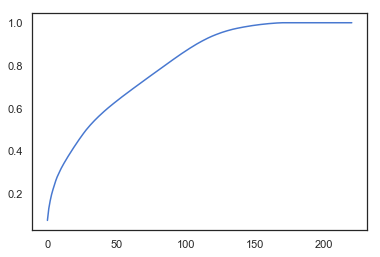

In [32]:
# Investigate the variance accounted for by each principal component.
variance_ratios = modelPCA.explained_variance_ratio_
cumulative_variance_ratios = []
for i in range(len(variance_ratios)):
    cumulative_variance_ratios.append(sum(variance_ratios[:i+1]))
n_components = 0
variance_threshold = 0.8
while cumulative_variance_ratios[n_components] < variance_threshold:
    n_components += 1
n_components += 1

print('the determined number of components', n_components)
plt.plot(cumulative_variance_ratios)

In [33]:
# Re-apply PCA to the data while selecting for number of components to retain.
decided_modelPCA = PCA(n_components=n_components)
decided_pcs = decided_modelPCA.fit_transform(cleaned_imputed_standardized_data)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Answer:
<br>
After running a PCA with all possible principle components, i.e. the number of principle components and data features are the same, I found 86 principle components were required to remain over 80% variance. Thus, 86 principle components will be used for the later analyses.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [34]:
# mapping function
def feat_weight(pca_obj, component_index, topk = 5):
    components = pd.DataFrame(np.round(pca_obj.components_, 4), columns = cleaned_data.columns)
    component = components.iloc[component_index, :]
    sorted_component = component.sort_values()
    top_features = {}
    for i in range(topk):
        top_features[sorted_component.index[i]] = sorted_component[i]
        top_features[sorted_component.index[-i-1]] = sorted_component[-i-1]
    return top_features

In [35]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

top_features_0 = feat_weight(decided_modelPCA, 0)
print(top_features_0)


{'MOBI_REGIO': -0.196, 'LP_STATUS_GROB_1.0': 0.187, 'FINANZ_MINIMALIST': -0.1811, 'HH_EINKOMMEN_SCORE': 0.1796, 'KBA05_ANTG1': -0.1806, 'wealth': 0.1766, 'PLZ8_ANTG1': -0.1754, 'PLZ8_ANTG3': 0.1734, 'KBA05_GBZ': -0.1726, 'PLZ8_ANTG4': 0.1687}


In [36]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

top_features_1 = feat_weight(decided_modelPCA, 1)
print(top_features_1)


{'generation': -0.2355, 'ALTERSKATEGORIE_GROB': 0.2219, 'FINANZ_SPARER': -0.2234, 'FINANZ_VORSORGER': 0.2136, 'FINANZ_UNAUFFAELLIGER': -0.209, 'ZABEOTYP_3.0': 0.1906, 'SEMIO_REL': -0.2027, 'SEMIO_ERL': 0.1688, 'FINANZ_ANLEGER': -0.199, 'SEMIO_LUST': 0.1547}


In [37]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

top_features_2 = feat_weight(decided_modelPCA, 2)
print(top_features_2)

{'ANREDE_KZ_2.0': -0.3282, 'ANREDE_KZ_1.0': 0.3282, 'SEMIO_KAEM': -0.2972, 'SEMIO_VERT': 0.3004, 'SEMIO_DOM': -0.2639, 'SEMIO_FAM': 0.2451, 'SEMIO_KRIT': -0.2507, 'SEMIO_SOZ': 0.241, 'SEMIO_ERL': -0.2009, 'SEMIO_KULT': 0.2408}


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Answer:
<br>
The positive and negative values are weights of features in the original data space. They quantify the relationship between those features and the corresponding principle components. If weight of a feature has large absolute value/is far from zero, the change of this feature in the original data space would result in a relatively large change on the corresponding principle component in the principle component space. A positive weight would result in the two changes would be in the same direction, while a negative weight would result in the opposite changes.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [62]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

scores = []
for count in range(10, 30):
    kmeans = KMeans(n_clusters=count)
    model = kmeans.fit(decided_pcs)
    score = np.abs(model.score(decided_pcs))
    scores.append(score)
    print(count)
    

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Text(0.5, 1.0, 'SSE vs. K')

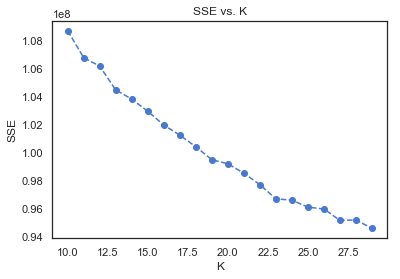

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
clusters = range(10, 30)
plt.plot(clusters, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')


In [38]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=28)
model = kmeans.fit(decided_pcs)
score = np.abs(model.score(decided_pcs))
labels = model.predict(decided_pcs)

pdtemp = pd.Series(labels)
print(pdtemp.value_counts())

3     59118
10    50835
22    47073
14    45640
9     42884
0     41970
16    41424
7     40891
8     39740
18    38816
2     37826
4     36035
26    33715
21    32687
20    29452
24    24375
25    24256
23    24221
19    21498
12    18890
5     18882
11    16569
15    16084
1     11041
13     8334
27     6817
6      4754
17     3351
dtype: int64


In [39]:
print(labels.shape)

(817178,)


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Answer:
<br>
I determined to use 28 centroids for clustering. I explored the relationship between the number of clusters (10-29) and the clustering error, i.e. the average distance. I found the error decreased with the increasing number of clusters. Thus, I chose a relatively large number, i.e. 28, as the number of clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [40]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')
cleaned_customer_data = clean_data(customers)

dataframe shape after nan transformation:  (191652, 85)
dataframe shape after dropping columns:  (191652, 81)
removed features:  ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
dataframe shape after dropping raws:  (144958, 81)
dataframe shape after transforming categorical features:  (144958, 218)
dataframe shape after dealing with feature (PRAEGENDE_JUGENDJAHRE):  (144958, 219)
dataframe shape after dealing with feature (CAMEO_INTL_2015):  (144958, 220)


In [41]:
# check if the 'customers' dataframe has the same columns as before
print(cleaned_data.shape)
print(cleaned_customer_data.shape)
general_columns = set(cleaned_data.columns.tolist())
customer_columns = set(cleaned_customer_data.columns.tolist())

column_difference = general_columns.difference(customer_columns)
print(column_difference)

(817178, 221)
(144958, 220)
{'GEBAEUDETYP_5.0'}


In [42]:
# deal with the missing column
cleaned_data.columns.tolist().index('GEBAEUDETYP_5.0')

155

In [43]:
# deal with the missing column
cleaned_customer_data.insert(155, 'GEBAEUDETYP_5.0', 0)

In [44]:
# check again if the 'customers' dataframe has the same columns as before
cleaned_customer_data.columns == cleaned_data.columns


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [45]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# imputation
imputer_customer = SimpleImputer(strategy='median')
cleaned_customer_data_impute = imputer_customer.fit_transform(cleaned_customer_data)

# standardization
cleaned_imputed_standardized_customer_data = standardizer.transform(cleaned_customer_data_impute)

# PCA/dimension reduction
decided_customer_pcs = decided_modelPCA.transform(cleaned_imputed_standardized_customer_data)

# clustering
customer_labels = model.predict(decided_customer_pcs)

# label results of clustering
pd.Series(customer_labels).value_counts()

16    26378
22    23019
3     13933
7     13242
26     9559
23     6748
8      6407
10     5882
18     4275
15     3976
25     3735
9      3501
5      3136
6      3124
19     2923
1      2838
17     2805
21     1583
27     1374
24     1142
13     1046
4       760
11      731
20      653
12      580
0       573
14      550
2       485
dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

unused dataset of general population:  74043
unused dataset of customers:  46694


C:\Users\Public\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


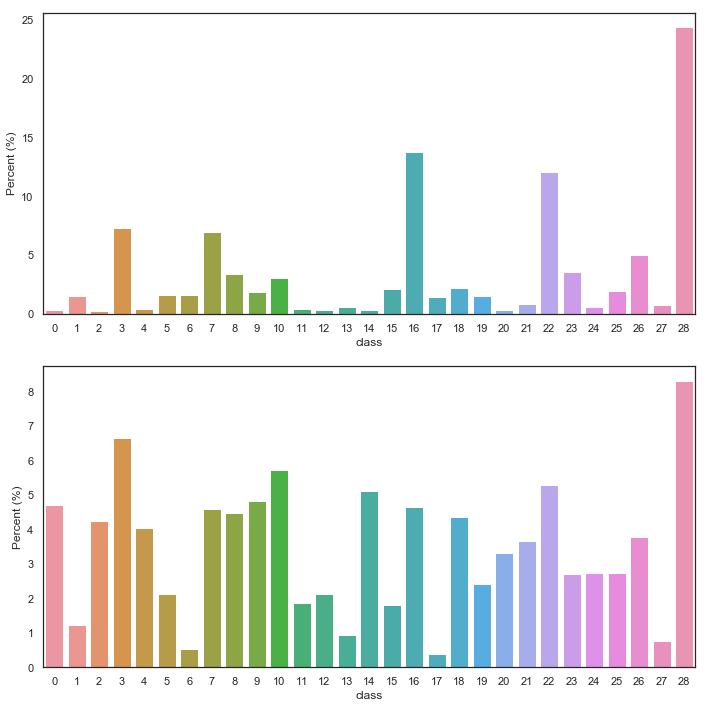

In [46]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# unused data for general population dataset and customer dataset
general_unused_data = azdias.shape[0] - labels.shape[0]
customer_unused_data = customers.shape[0] - customer_labels.shape[0]
print('unused dataset of general population: ', general_unused_data)
print('unused dataset of customers: ', customer_unused_data)

# append missing value cluster to general population dataset
gen_results = pd.DataFrame(labels, columns = ['class'])
missing_gen = np.array([28]*general_unused_data)
missing_gen_data = pd.DataFrame(missing_gen, columns = ['class'])
general_total = pd.concat([gen_results, missing_gen_data]).reset_index(drop=True)

# append missing value cluster to customer dataset
cus_results = pd.DataFrame(customer_labels, columns = ['class'])
missing_cus = np.array([28]*customer_unused_data)
missing_cus_data = pd.DataFrame(missing_cus, columns = ['class'])
customer_total = pd.concat([cus_results, missing_cus_data]).reset_index(drop=True)

# visualization: customer vs. general population
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2, 1, figsize=(10, 10))

sns.barplot(x="class", y="class", data=customer_total, estimator=lambda x: len(x) / len(customer_total) * 100, ax=axes[0])
sns.barplot(x="class", y="class", data=general_total, estimator=lambda x: len(x) / len(general_total) * 100, ax=axes[1])

plt.setp(axes, ylabel="Percent (%)")
plt.tight_layout()

In [47]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cus_indices = cus_results.index[cus_results['class'] == 16].tolist()
gen_indices = gen_results.index[gen_results['class'] == 16].tolist()

cus_origin_data = pd.DataFrame(np.array(cleaned_customer_data), columns = cleaned_data.columns).iloc[cus_indices, :]
gen_origin_data = pd.DataFrame(np.array(cleaned_data), columns = cleaned_data.columns).iloc[gen_indices, :]

cus_means = cus_origin_data.mean(axis=0, skipna=True)
gen_means = gen_origin_data.mean(axis=0, skipna=True)

relative_differences = (cus_means - gen_means) / gen_means
sorted_relative_differences = relative_differences.sort_values()
sorted_relative_differences


GEBAEUDETYP_4.0        -1.000000
LP_FAMILIE_GROB_1.0    -1.000000
LP_FAMILIE_FEIN_1.0    -1.000000
ZABEOTYP_5.0           -0.960458
LP_FAMILIE_GROB_2.0    -0.941837
LP_FAMILIE_FEIN_2.0    -0.941837
LP_STATUS_FEIN_2.0     -0.912756
FINANZTYP_4.0          -0.865755
GEBAEUDETYP_2.0        -0.861435
FINANZTYP_1.0          -0.837183
ZABEOTYP_6.0           -0.818262
FINANZTYP_3.0          -0.777261
LP_STATUS_GROB_1.0     -0.770185
LP_STATUS_FEIN_1.0     -0.730088
GFK_URLAUBERTYP_12.0   -0.686671
LP_STATUS_FEIN_4.0     -0.630494
NATIONALITAET_KZ_2.0   -0.625419
CAMEO_DEUG_2015_nan    -0.607400
CAMEO_DEU_2015_nan     -0.607400
NATIONALITAET_KZ_3.0   -0.591809
ZABEOTYP_2.0           -0.562965
OST_WEST_KZ_O          -0.555652
GFK_URLAUBERTYP_2.0    -0.554110
LP_FAMILIE_FEIN_6.0    -0.551314
ZABEOTYP_4.0           -0.538154
ANREDE_KZ_2.0          -0.510259
CJT_GESAMTTYP_6.0      -0.487234
GEBAEUDETYP_6.0        -0.476533
CAMEO_DEU_2015_3A      -0.437417
GREEN_AVANTGARDE_0.0   -0.413280
          

In [48]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cus_indices_under = cus_results.index[cus_results['class'] == 14].tolist()
gen_indices_under = gen_results.index[gen_results['class'] == 14].tolist()


cus_origin_data_under = pd.DataFrame(np.array(cleaned_customer_data), columns = cleaned_data.columns).iloc[cus_indices_under, :]

gen_origin_data_under = pd.DataFrame(np.array(cleaned_data), columns = cleaned_data.columns).iloc[gen_indices_under, :]

cus_means_under = cus_origin_data_under.mean(axis=0, skipna=True)
gen_means_under = gen_origin_data_under.mean(axis=0, skipna=True)

relative_differences_under = (cus_means_under - gen_means_under) / gen_means_under
sorted_relative_differences_under = relative_differences_under.sort_values()
sorted_relative_differences_under


LP_FAMILIE_GROB_3.0     -1.000000
LP_FAMILIE_FEIN_10.0    -1.000000
LP_FAMILIE_FEIN_9.0     -1.000000
LP_FAMILIE_FEIN_5.0     -1.000000
LP_FAMILIE_FEIN_4.0     -1.000000
GEBAEUDETYP_4.0         -1.000000
ANZ_TITEL               -1.000000
GEBAEUDETYP_6.0         -1.000000
CAMEO_DEU_2015_1B       -1.000000
CAMEO_DEU_2015_1D       -1.000000
CAMEO_DEU_2015_1E       -1.000000
CAMEO_DEU_2015_2A       -1.000000
CAMEO_DEU_2015_2C       -1.000000
ANREDE_KZ_1.0           -1.000000
CAMEO_DEU_2015_3A       -1.000000
CAMEO_DEU_2015_3B       -1.000000
LP_FAMILIE_FEIN_11.0    -1.000000
VERS_TYP_nan            -1.000000
GEBAEUDETYP_2.0         -1.000000
LP_FAMILIE_GROB_5.0     -1.000000
SHOPPER_TYP_nan         -1.000000
LP_STATUS_FEIN_10.0     -1.000000
LP_STATUS_GROB_5.0      -1.000000
LP_STATUS_FEIN_8.0      -1.000000
CAMEO_DEU_2015_6D       -0.746233
CAMEO_DEU_2015_5B       -0.665396
CAMEO_DEU_2015_5C       -0.617595
CAMEO_DEUG_2015_1       -0.524459
CAMEO_DEU_2015_1A       -0.490909
CAMEO_DEU_2015

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

As for cluster 16, its percentage in customer dataset is much higher than that in general people dataset, which suggests this cluster could represent some target customers. In this cluster, the relative differences between feature means of customer dataset and the general people dataset are calculated.
The relative differences suggest population that are relatively popular with the mail-order company include:
1) title holder-households as their social status
2) investor as their most descriptive financial type for individual
3) new houseowners as their social status

As for cluster 14, its percentage in customer dataset is much lower than that in general people dataset, which suggests this cluster could represent some nontarget customers. In this cluster, the relative differences between feature means of customer dataset and the general people dataset are calculated.
The relative differences suggest population that are relatively unpopular with the mail-order company include:
1) young family as their family type
2) family with teenager  as their family type
3) money-saver as the most descriptive financial type for individual 
